<a href="https://colab.research.google.com/github/Marcll0/R/blob/main/MCMC_Exponencial_e_Multivariado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Simulação por MCMC de uma distribuição exponencial**

Para amostrar uma função por MCMC é preciso definir a distribuição de probabilidades da função a ser amostrada e a função de propostas.**negrito**

In [1]:
# reprodutibilidade
set.seed(1234)
# função a ser amostrada
p = function(x) dexp(x, log = FALSE)

A função proposta deve propor valôres dentro do espaço amostral da distribuição de probabilidades considerada.

A distribuição exponencial é definida para x>0
, enquanto que uma função proposta gaussiana pode ter valores negativos.

Assim, precisamos modificar a função proposta gaussiana para ela propor apenas valores positivos:

In [3]:
funcao_proposta = function(x){
a = -1
while(a < 0){a = rnorm(1,mean = x, sd= 1)}
return(a)}

In [5]:
# função que vai gerar a cadeia via MCMC com o algoritmo de Metropolis-Hastings

mcmc = function(xini, niter){
# defino o vetor que conterá os valores da cadeia
    cadeia = array(niter+1)
# inicialização da cadeia
    cadeia[1] = xini
# loop para gerar a cadeia
    for (i in 1:niter){
# obtenho uma proposta
        proposta = funcao_proposta(cadeia[i])
# razão entre o valor proposto nesta iteração e o valor anterior da cadeia
        probab = p(proposta)/p(cadeia[i])
# gero um número aleatório uniformemente distribuído entre 0 e 1
      runif1=runif(1)
# testo se a proposta é aceita ou não
        if (probab > runif1) {
# aceita
            cadeia[i+1] = proposta}
        else{
# não aceita: usa o valor anterior da cadeia
            cadeia[i+1] = cadeia[i]}
    }
# retorna a cadeia
    return(cadeia)
}

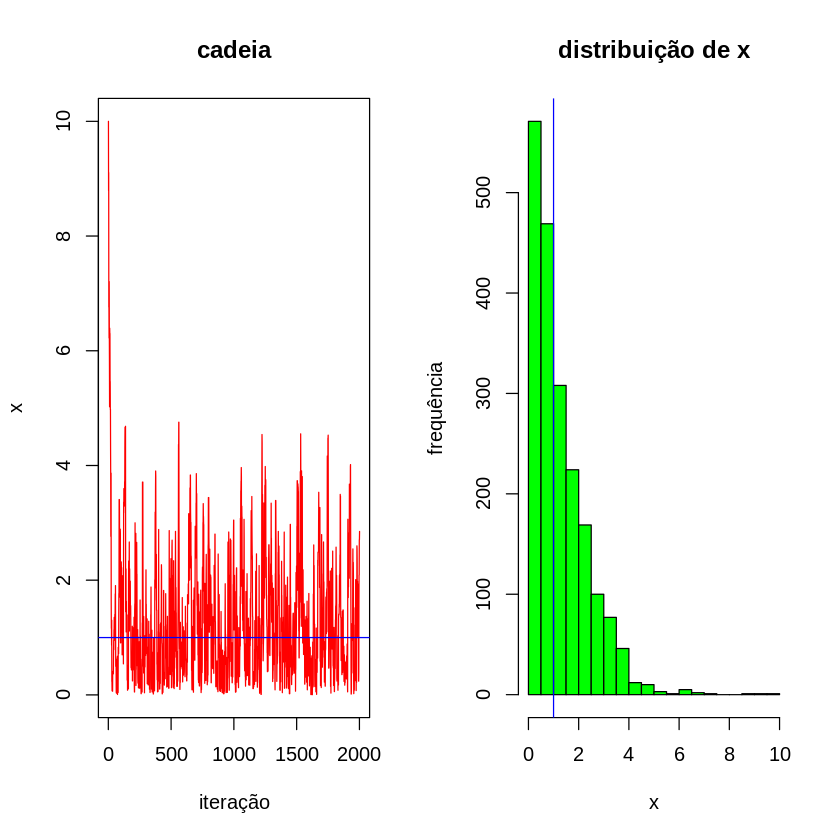

In [6]:
## Vamos começar "longe" do valor esperado:

xini=10
niter=2000

#mcmc
y = mcmc(xini,niter)

#visualização da cadeia:
par(mfrow = c(1,2))
x=seq(1,niter+1,1)
plot(x,y,type='l',col='red',ylab='x',xlab='iteração',main='cadeia')
# adiciona uma reta horizontal
abline(h = 1, col="blue" )
hist(y,col='green',main='distribuição de x',xlab='x',ylab='frequência',breaks=20)
# adiciona uma reta vertical
abline(v = 1, col="blue" )

**Simulações de distribuições multivariadas**

MCMC é muito útil também para simular distribuições multivariadas.

Vamos ilustrar isso com a simulação de pares (x,y) de acordo com uma distribuição gaussiana bivariada com coeficiente de correlação ρ:

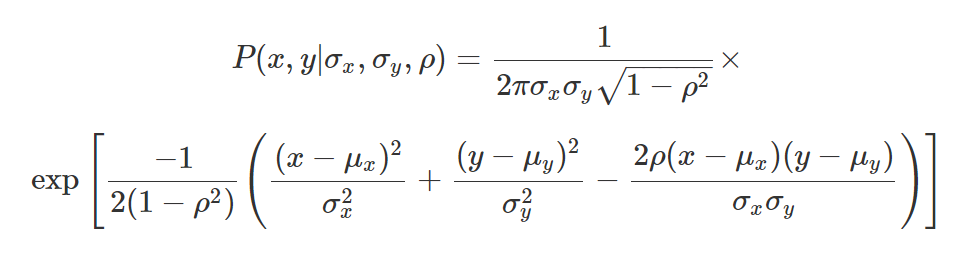

* se se ρ≈0 a correlação é nula ou fraca;
* se ρ≈±1 a correlação/anti-correlação é forte.

aqui definimos os parâmetros da distribuição que vamos simular:

In [7]:
rho=0.5
media.x=3
sd.x=2
media.y=7
sd.y=1

# constantes
c1=1/(2*pi*sd.x*sd.y*sqrt(1-rho^2))
c2=1/(2*(1-rho^2))
c3=2*rho/(sd.x*sd.y)

* Vamos gerar um conjunto de pontos amostrados de uma gaussiana bivariada por MCMC
* Ao invés de x e y vamos considerar um vetor com as variáveis da distribuição: param[1]=x e param[2]=y

In [8]:
npar=2

#função a ser amostrada
p = function(param){
z=(param[1]-media.x)^2/sd.x^2-c3*(param[1]-media.x)*(param[2]-media.y)+(param[2]-media.y)^2/sd.y^2
pxy=c1*exp(-c2*z)

# vamos trabalhar com o logaritmo da distribuição de probabilidades
return(log(pxy))
}

# função proposta gaussiana para cada parâmetro
funcao_proposta = function(param){rnorm(2,mean = param, sd= c(0.1,0.3))}

# mcmc adaptado para mais de uma variável
mcmc2 = function(xini, iterations){
    cadeia = array(dim = c(iterations+1,npar))
    cadeia[1,] = xini
    for (i in 1:iterations){
        proposta = funcao_proposta(cadeia[i,])
# como a probabilidade está em log
        probab = exp(p(proposta) - p(cadeia[i,]))
        if (runif(1) < probab){
            cadeia[i+1,] = proposta}
        else{
            cadeia[i+1,] = cadeia[i,]}
    }
    return(cadeia)
}

In [9]:
# Agora inicializamos e rodamos a simulação:

xini = c(0,10)
set.seed(234234)
cadeiamc = mcmc2(xini, 100000)

# burn-in
burnin = 1000
aceitacao = 1-mean(duplicated(cadeiamc[-(1:burnin),]))
aceitacao

[1] 0.8886072

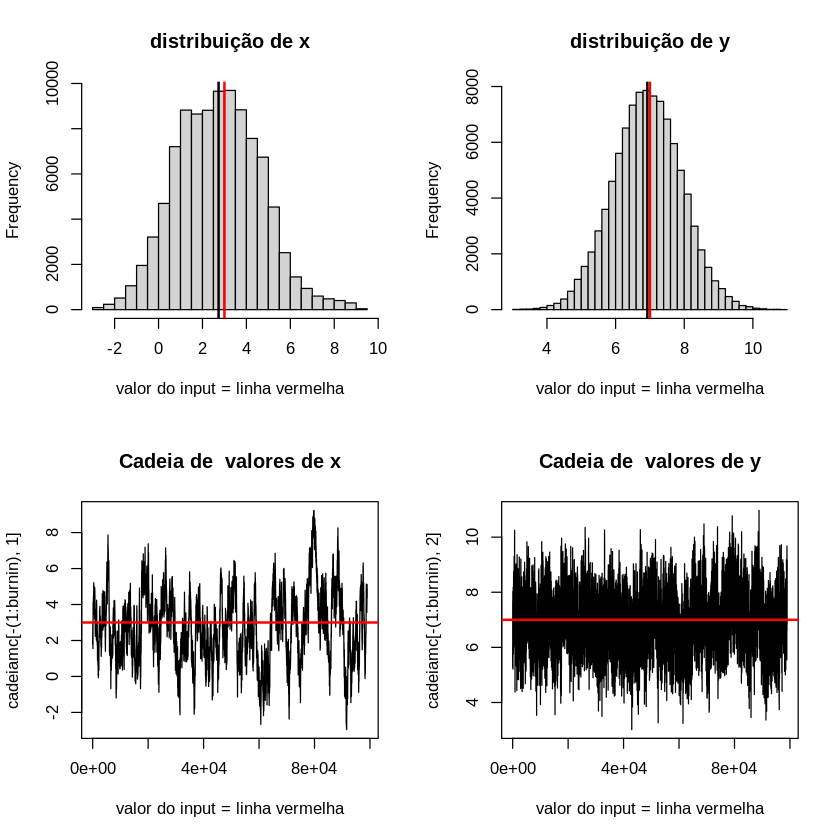

In [10]:
# visualização
# notem como se pode remover o burn-in da cadeia
par(mfrow = c(2,2))
hist(cadeiamc[-(1:burnin),1],nclass=30, , main="distribuição de x", xlab="valor do input = linha vermelha")
abline(v = mean(cadeiamc[-(1:burnin),1]),lwd=2)
abline(v = media.x, col="red",lwd=2)
hist(cadeiamc[-(1:burnin),2],nclass=30, main="distribuição de y", xlab="valor do input = linha vermelha")
abline(v = mean(cadeiamc[-(1:burnin),2]),lwd=2)
abline(v = media.y, col="red",lwd=2)
plot(cadeiamc[-(1:burnin),1], type = "l", xlab="valor do input = linha vermelha" , main = "Cadeia de  valores de x", )
abline(h = media.x, col="red",lwd=2)
plot(cadeiamc[-(1:burnin),2], type = "l", xlab="valor do input = linha vermelha" , main = "Cadeia de  valores de y", )
abline(h = media.y, col="red",lwd=2)

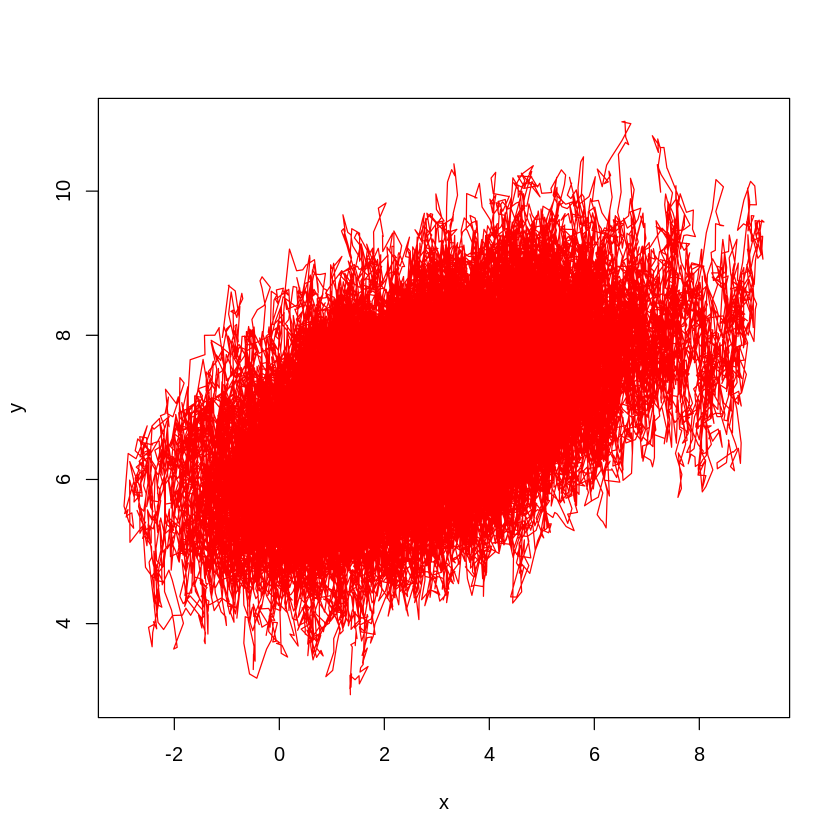

In [11]:
# essa figura sugere que deve-se aumentar o tamanho da cadeia

par(mfrow = c(1,1))
plot(cadeiamc[-(1:burnin),1],cadeiamc[-(1:burnin),2],xlab="x", ylab="y" , col="red", type = "l")

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



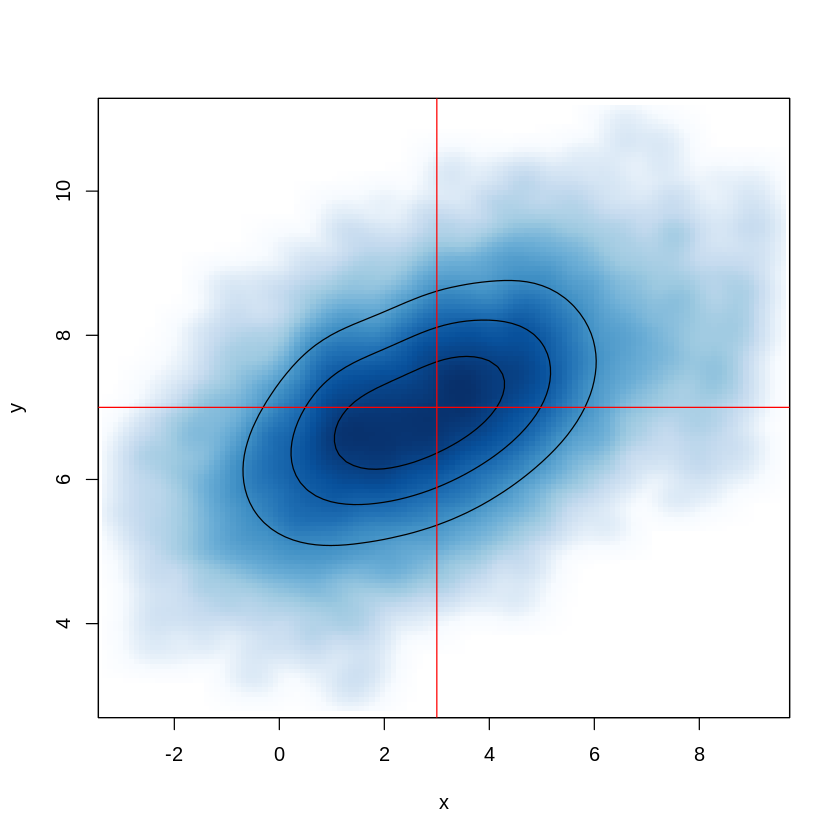

In [12]:
# Outra visualização das amostras simuladas:

library(KernSmooth)

ca=cadeiamc[-(1:burnin),1]
cb=cadeiamc[-(1:burnin),2]
smoothScatter(ca,cb,nrpoints=0,add=FALSE,xlab="x",ylab="y")
# contornos
Ndim = 101
z = cbind(ca,cb)
xmax = max(ca)
xmin = min(ca)
ymax = max(cb)
ymin = min(cb)
deltax = (xmax-xmin)
deltay = (ymax-ymin)
bw.x = 6*deltax/Ndim
bw.y = 6*deltay/Ndim
dens = bkde2D(z,bandwidth=c(bw.x,bw.y),gridsize=c(Ndim,Ndim))
contour(dens$x1,dens$x2,dens$fhat,add=T,drawlabels=F,nlevels=5)
abline(v = media.x, col="red" )
abline(h = media.y, col="red" )

In [13]:
# Os valores médios dos x e y simulados podem ser comparados com os parâmetros iniciais:

# valor médio de x
mediax=mean(cadeiamc[-(1:burnin),1])
mediax

[1] 2.734159

In [14]:
# valor inicial da média de x
media.x

[1] 3

In [15]:
# valor médio de y
mediay=mean(cadeiamc[-(1:burnin),2])
mediay

[1] 6.925175

In [16]:
# valor inicial da média de y
media.y

[1] 7

fonte: http://www.astro.iag.usp.br/~laerte/aga0505_22/R4.html